In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.utils import plot_model

Cargamos los datos a modelar. Inicialmente probaremos modelos sólo con 2 meses (noviembre y diciembre 2023).

In [2]:
df = pd.read_parquet('data_export/prueba_ml.parquet')
df.head()

,fecha,hora,temperature_2m,rain,relative_humidity_2m,snowfall,Bronx,Brooklyn,Manhattan,Queens,Staten Island,año,mes,dia
3,2023-11-01,0.0,8.6725,0.1,60.153034,0.0,3,12,2196,232,1,2023,11,1
4,2023-11-01,1.0,8.5725,0.0,60.344471,0.0,2,12,1521,55,0,2023,11,1
5,2023-11-01,2.0,8.3225,0.1,62.933163,0.0,3,8,1214,16,0,2023,11,1
6,2023-11-01,3.0,8.0725,0.0,66.100021,0.0,0,13,854,20,0,2023,11,1
7,2023-11-01,4.0,7.7725,0.0,72.938622,0.0,12,20,654,25,0,2023,11,1


In [3]:
df.reset_index(inplace=True, drop=True)

In [145]:
columnas_X = ['año', 'mes', 'dia', 'hora', 'temperature_2m', 'rain', 'relative_humidity_2m', 'snowfall']
X = df[columnas_X]

columnas_Y = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
Y = df[columnas_Y]

Grafiquemos para ver como es la demanda:

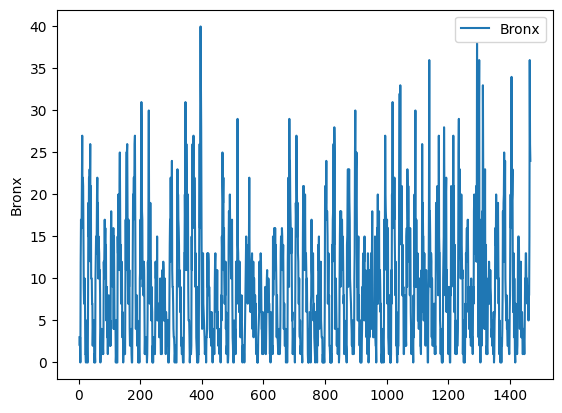

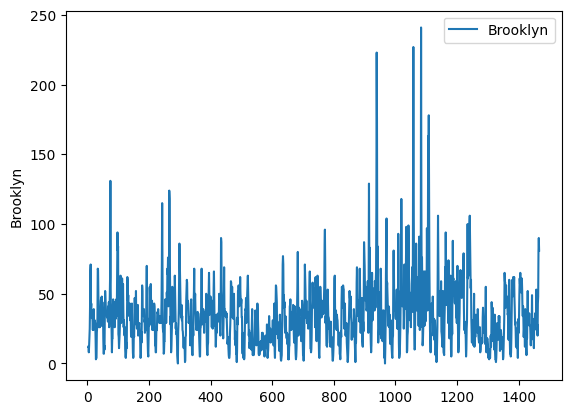

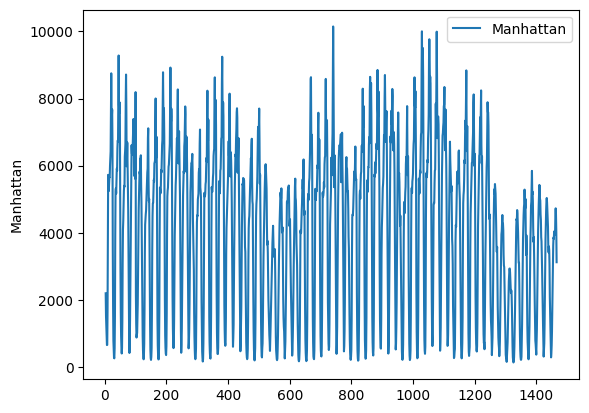

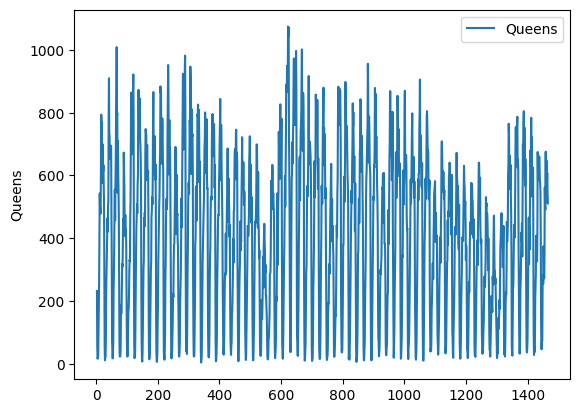

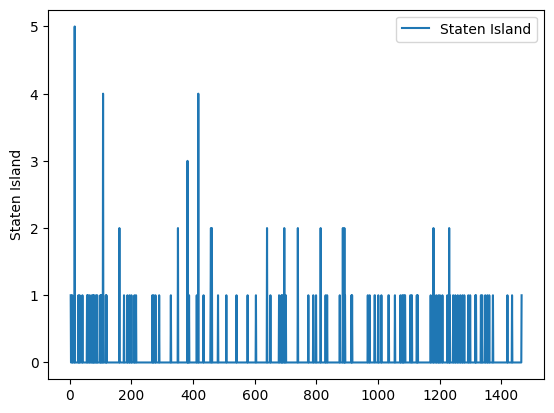

In [4]:
for i in columnas_Y:
    sns.lineplot(x=df.index, y=df[i], label=i)
    plt.legend()
    plt.show()

Definamos una función que retorna los arrays de X e Y con la forma que requiere la entrada a la capa  LSTM

In [5]:
def generador_X_Y(X, Y, p):
    ''' 
    A partir dos dataframes, X e Y, y los pasos de tiempo, retorna un tensor 3D para X y una array 2D para Y.
    args:
    - X: pandas dataframe, con m filas (muestras) y n columnas (features)
    - Y: pandas dataframe, con m filas (muestras) e y columnas (longitud de vector de respuesta)
    - p (int): número de pasos de tiempo a considerar
    returns:
    - X_reshaped: numpy array de forma (m, p, n)
    - Y_reshaped: numpy array de forma (m, y)
    '''
    
    X_reshaped_list = list()
    Y_rehaped_list = list()

    m = len(X)
    X = np.array(X)
    Y = np.array(Y)

    for i in range(m-p):
        X_reshaped_list.append(X[i:i+p, :])
        Y_rehaped_list.append(Y[i+p, :])
    
    X_reshaped = np.array(X_reshaped_list)
    Y_reshaped = np.array(Y_rehaped_list)

    return X_reshaped, Y_reshaped

Veamos las shape iniciales:

In [6]:
print('Shape de X:', X.shape)
print('Shape de Y:', Y.shape)

Shape de X: (1464, 8)
Shape de Y: (1464, 5)


Vemos que tanto X como Y tienen 1464 muestras, X tiene 8 features, e Y contiene vectores de 5 componentes (la demanda para cada distrito).

Hagamos una primera prueba de LSTM




10/10 [==============================] - 0s 2ms/step - loss: 0.0232
Número de pasos 1 Loss (MSE): 0.023173408582806587
10/10 [==============================] - 0s 679us/step - loss: 0.0272
Número de pasos 2 Loss (MSE): 0.027217291295528412
10/10 [==============================] - 0s 2ms/step - loss: 0.0199
Número de pasos 3 Loss (MSE): 0.01989796571433544
10/10 [==============================] - 0s 295us/step - loss: 0.0253
Número de pasos 4 Loss (MSE): 0.025324072688817978
9/9 [==============================] - 0s 2ms/step - loss: 0.0161
Número de pasos 5 Loss (MSE): 0.016118435189127922
9/9 [==============================] - 0s 2ms/step - loss: 0.0253
Número de pasos 6 Loss (MSE): 0.025250447914004326
9/9 [==============================] - 0s 1ms/step - loss: 0.0177
Número de pasos 7 Loss (MSE): 0.01773245818912983
9/9 [==============================] - 0s 1ms/step - loss: 0.0239
Número de pasos 8 Loss (MSE): 0.023930711671710014
9/9 [==============================] - 0s 2ms/step 

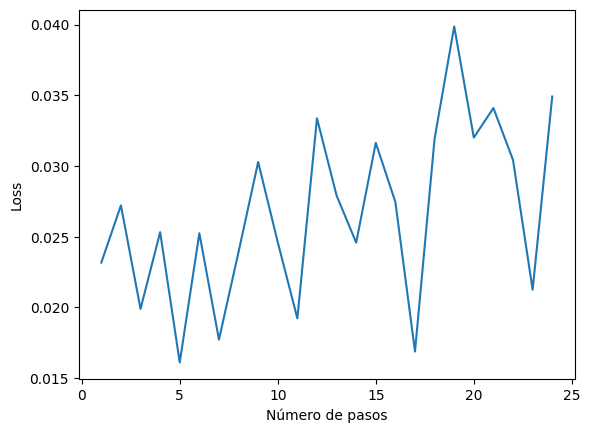

In [7]:
# Normalizar los datos
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

# Generamos listas vacías para almacenar datos
lista_loss = []
lista_pasos = []

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, shuffle=False)

for pasos in range(1,25):

    # Reshape de los datos para que sean 3D (número de muestras, número de pasos de tiempo, número de características)
    X_train_reshaped, Y_train_reshaped = generador_X_Y(X_train, Y_train, pasos)
    X_test_reshaped, Y_test_reshaped = generador_X_Y(X_test, Y_test, pasos)

    # Construimos el modelo LSTM
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    model.add(Dense(units=Y_train_reshaped.shape[1]))  # Capa de salida con tantas neuronas como variables de salida
    model.compile(optimizer='adam', loss='mse')  # Compilación del modelo

    #model.summary()

    # Entrenar el modelo
    model.fit(X_train_reshaped, Y_train_reshaped, epochs=50, batch_size=32, validation_data=(X_test_reshaped, Y_test_reshaped), verbose=0)

    # Evaluación del modelo
    loss = model.evaluate(X_test_reshaped, Y_test_reshaped)
    print('Número de pasos',pasos ,'Loss (MSE):', loss)
    lista_pasos.append(pasos)
    lista_loss.append(loss)

sns.lineplot(x= lista_pasos, y=lista_loss)
plt.xlabel('Número de pasos')
plt.ylabel('Loss')
plt.show()


Vemos que hay un mínimo en 5 numero de pasos, es decir, las predicciones toman en cuenta la demanda las 10 horas anteriores. <br>
Veamos ese modelo en particular:

Epoch 1/50
37/37 [==============================] - 1s 8ms/step - loss: 0.0807 - val_loss: 0.0562
Epoch 2/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0345 - val_loss: 0.0544
Epoch 3/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0305 - val_loss: 0.0485
Epoch 4/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0275 - val_loss: 0.0379
Epoch 5/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0245 - val_loss: 0.0356
Epoch 6/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0209 - val_loss: 0.0380
Epoch 7/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0175 - val_loss: 0.0318
Epoch 8/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0151 - val_loss: 0.0318
Epoch 9/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0138 - val_loss: 0.0227
Epoch 10/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0130 - val_loss: 0.0277
Epoch 11/50
37/37 [

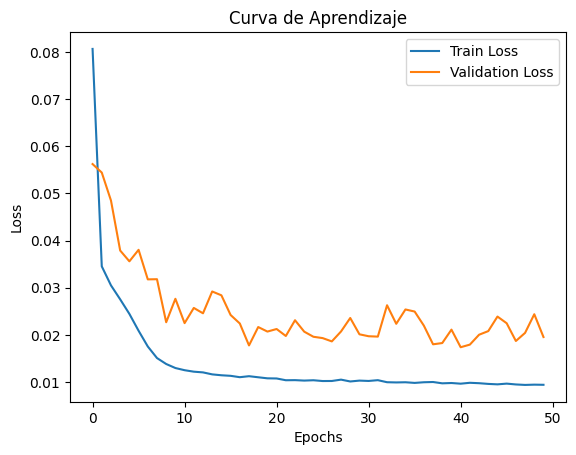

In [9]:
# Normalizamos los datos
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, shuffle=False)

# Reshape de los datos para que sean 3D (número de muestras, número de pasos de tiempo, número de características)
X_train_reshaped, Y_train_reshaped = generador_X_Y(X_train, Y_train, 5)
X_test_reshaped, Y_test_reshaped = generador_X_Y(X_test, Y_test, 5)

# Construimos el modelo LSTM
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dense(units=Y_train_reshaped.shape[1]))  # Capa de salida con tantas neuronas como variables de salida
model.compile(optimizer='adam', loss='mse')  # Compilación del modelo

# Entrenamos el modelo y guardamos el historial de entrenamiento
history = model.fit(X_train_reshaped, Y_train_reshaped, epochs=50, batch_size=32, validation_data=(X_test_reshaped, Y_test_reshaped), verbose=1)

# Extraemos los valores de la función de pérdida del historial de entrenamiento
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Graficamos la curva de aprendizaje
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Curva de Aprendizaje')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [3]:
def graficar_pred_test(X_test_reshaped, Y_test_reshaped, modelo, scaler_Y):
    Y_test_df = pd.DataFrame(Y_test_reshaped, columns=columnas_Y)
    Y_test_original = scaler_Y.inverse_transform(Y_test_df)
    Y_test_original_df = pd.DataFrame(Y_test_original, columns=columnas_Y)

    Y_predict = modelo.predict(X_test_reshaped)
    Y_predict_df = pd.DataFrame(Y_predict, columns=columnas_Y)
    Y_predict_original = scaler_Y.inverse_transform(Y_predict_df)
    Y_predict_original_df = pd.DataFrame(Y_predict_original, columns=columnas_Y)

    for i in columnas_Y:
        sns.lineplot(x=Y_predict_original_df.index, y=Y_predict_original_df[i], label='Predicción')
        sns.lineplot(x=Y_test_original_df.index, y=Y_test_original_df[i], label= 'Real')
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()

9/9 [==============================] - 0s 1ms/step


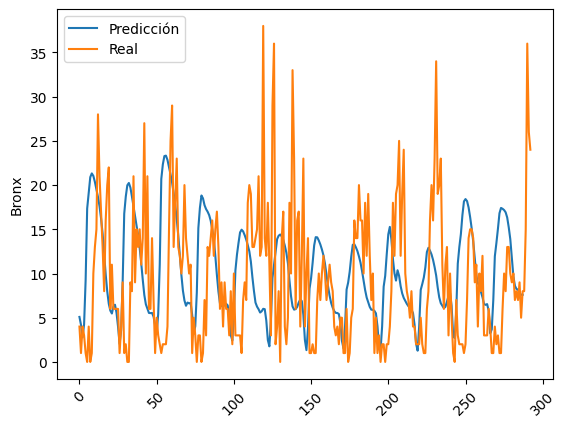

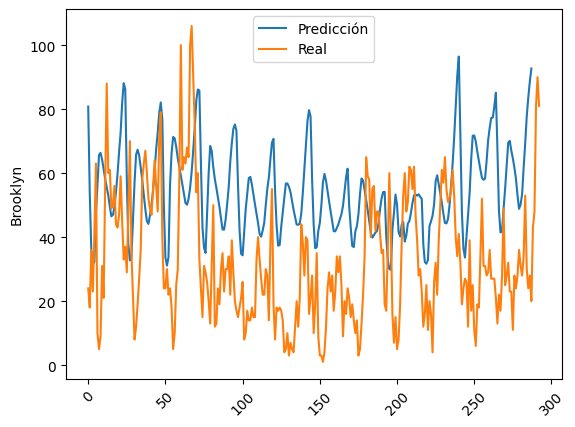

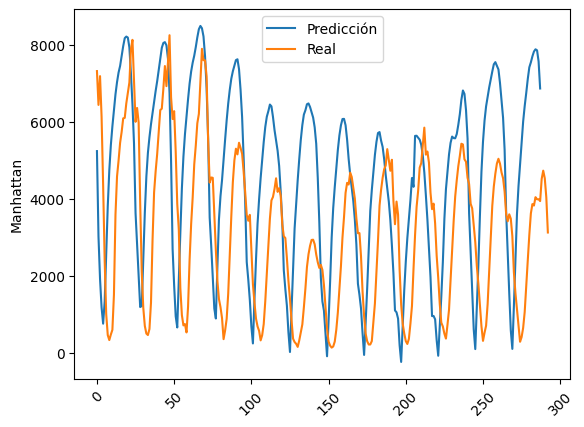

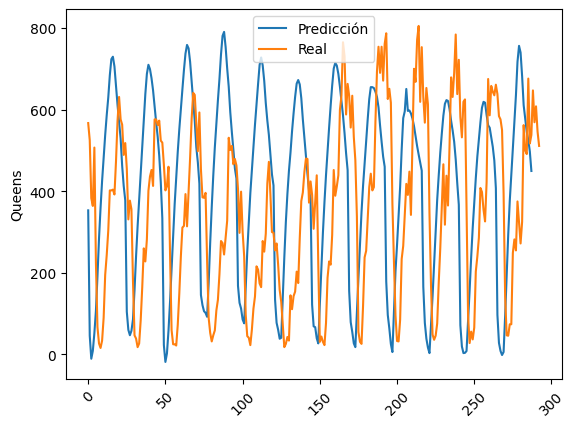

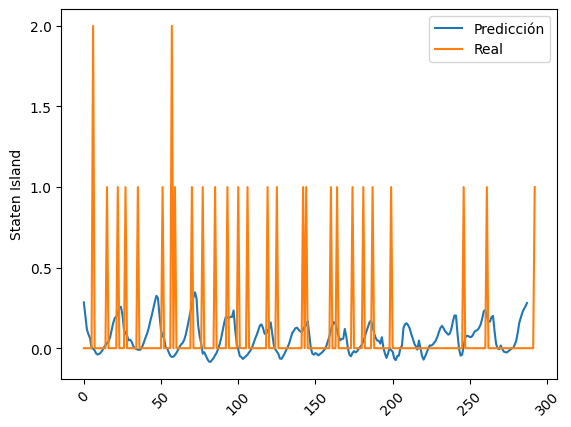

In [10]:
graficar_pred_test(X_test_reshaped, Y_test_reshaped)

Vemos que hay mucho error en las predicciones. Vamos a replantear el modelo de la siguiente manera: <br>
Sea 'p' el número de pasos de tiempo a utilizar. <br>
Para predecir la demanda al tiempo t, se utilizarán los valores de las variables X al tiempo t, t-1, t-2, ..., t-p y la demanda (Y) en los tiempos t-p, t-p+1, ..., t-1. <br>
Para ello tenemos que reconfigurar las variables de entrada del modelo.

In [4]:
def generador_X_Y_lag(X, Y, p):
    ''' 
    A partir dos dataframes, X e Y, y los pasos de tiempo, retorna un tensor 3D para X y una array 2D para Y.
    args:
    - X: pandas dataframe, con m filas (muestras) y n columnas (features)
    - Y: pandas dataframe, con m filas (muestras) e y columnas (longitud de vector de respuesta)
    - p (int): número de pasos de tiempo a considerar
    returns:
    - X_reshaped: numpy array de forma (m, p, n+p)
    - Y_reshaped: numpy array de forma (m, y)
    '''
    
    X_reshaped_list = list()
    #Y_rehaped_list = list()

    X = pd.DataFrame(X)
    Y = pd.DataFrame(Y)

    for i in range(1, p+1):
        X = pd.concat([X, Y.shift(i)], axis=1)      # agrega la demanda de la hora i anterior

    X.dropna(how='any', inplace=True)
    Y = Y.iloc[2*p-1:-1,:]
    
    m = len(X)
    X = np.array(X)
    Y = np.array(Y)

    for i in range(m-p):
        X_reshaped_list.append(X[i:i+p, :])
        #Y_rehaped_list.append(Y[i+p, :])
    
    X_reshaped = np.array(X_reshaped_list)
    Y_reshaped = np.array(Y)

    return X_reshaped, Y_reshaped

Definamos una función para evaluar modelos más facilmente:

In [5]:
def evaluar_modelos_pasos(X, Y, nro_pasos=25, nro_capas_lstm=1, unidades_capa= [50], loss_= 'mse', act_salida='linear', act_lstm= 'relu'):
    # Normalizamos los datos
    scaler_X = MinMaxScaler()
    scaler_Y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)
    Y_scaled = scaler_Y.fit_transform(Y)

    # Generamos listas vacías para almacenar datos
    lista_loss = []
    lista_pasos = []

    # Dividimos los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, shuffle=False)

    for pasos in range(1,nro_pasos):

        # Reshape de los datos para que sean 3D (número de muestras, número de pasos de tiempo, número de características)
        X_train_reshaped, Y_train_reshaped = generador_X_Y_lag(X_train, Y_train, pasos)
        X_test_reshaped, Y_test_reshaped = generador_X_Y_lag(X_test, Y_test, pasos)

        # Construimos el modelo LSTM
        model = Sequential()
        for i in range(nro_capas_lstm):
            model.add(LSTM(units=unidades_capa[i], activation=act_lstm, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
        model.add(Dense(units=Y_train_reshaped.shape[1], activation= act_salida))  # Capa de salida con tantas neuronas como variables de salida
        model.compile(optimizer='adam', loss=loss_)  # Compilación del modelo

        # Entrenamos el modelo
        model.fit(X_train_reshaped, Y_train_reshaped, epochs=50, batch_size=32, validation_data=(X_test_reshaped, Y_test_reshaped), verbose=0)

        # Evaluamos del modelo
        loss = model.evaluate(X_test_reshaped, Y_test_reshaped)
        print('Número de pasos',pasos ,'Loss (MSE):', loss)
        lista_pasos.append(pasos)
        lista_loss.append(loss)

    sns.lineplot(x= lista_pasos, y=lista_loss)
    plt.title('Evaluación de modelos LSTM')
    plt.xlabel('Número de pasos')
    plt.ylabel('Loss')
    plt.show()

    mejor_paso = lista_pasos[lista_loss.index(min(lista_loss))]

    return mejor_paso

Definamos una función también para construir un modelo y hacer su curva de aprendizaje:

In [6]:
def construir_modelo(X, Y, nro_pasos, nro_capas_lstm=1, unidades_capa= [50], loss_= 'mse', act_salida='linear', act_lstm= 'relu'):
    # Normalizar los datos
    scaler_X = MinMaxScaler()
    scaler_Y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)
    Y_scaled = scaler_Y.fit_transform(Y)

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, shuffle=False)

    # Reshape de los datos para que sean 3D (número de muestras, número de pasos de tiempo, número de características)
    X_train_reshaped, Y_train_reshaped = generador_X_Y_lag(X_train, Y_train, nro_pasos)
    X_test_reshaped, Y_test_reshaped = generador_X_Y_lag(X_test, Y_test, nro_pasos)

    # Construimos el modelo LSTM
    model = Sequential()
    if nro_capas_lstm > 1:

        model.add(LSTM(units=unidades_capa[0], activation=act_lstm, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True))
        for i in range(1, nro_capas_lstm-1):
            model.add(LSTM(units=unidades_capa[i], activation=act_lstm, return_sequences=True))
        model.add(LSTM(units=unidades_capa[-1], activation=act_lstm))
        model.add(Dense(units=Y_train_reshaped.shape[1], activation=act_salida))
    
    if nro_capas_lstm == 1:
        model.add(LSTM(units=unidades_capa[0], activation=act_lstm, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
        model.add(Dense(units=Y_train_reshaped.shape[1], activation=act_salida))

    model.compile(optimizer='adam', loss=loss_)  # Compilación del modelo 
    
    model.summary()

    # Entrenamos el modelo y guardamos el historial de entrenamiento
    history = model.fit(X_train_reshaped, Y_train_reshaped, epochs=50, batch_size=32, validation_data=(X_test_reshaped, Y_test_reshaped), verbose=0)

    # Extraemos los valores de la función de pérdida del historial de entrenamiento
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    final_loss = history.history['val_loss'][-1]
    print("Valor final de Loss:", final_loss)
    
    # Graficamos la curva de aprendizaje
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Curva de Aprendizaje')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model, X_test_reshaped, Y_test_reshaped, scaler_Y

Probemos la cantidad de pasos nuevamente:

10/10 [==============================] - 0s 9ms/step - loss: 0.0074
Número de pasos 1 Loss (MSE): 0.0074339816346764565
10/10 [==============================] - 0s 3ms/step - loss: 0.0077
Número de pasos 2 Loss (MSE): 0.007688830140978098
9/9 [==============================] - 0s 22ms/step - loss: 0.0078
Número de pasos 3 Loss (MSE): 0.007838776335120201
9/9 [==============================] - 0s 0s/step - loss: 0.0079
Número de pasos 4 Loss (MSE): 0.007901097647845745
9/9 [==============================] - 0s 2ms/step - loss: 0.0084
Número de pasos 5 Loss (MSE): 0.00838435348123312
9/9 [==============================] - 0s 2ms/step - loss: 0.0100
Número de pasos 6 Loss (MSE): 0.010002950206398964
9/9 [==============================] - 0s 2ms/step - loss: 0.0079
Número de pasos 7 Loss (MSE): 0.007875506766140461
9/9 [==============================] - 0s 2ms/step - loss: 0.0077
Número de pasos 8 Loss (MSE): 0.0077133504673838615
9/9 [==============================] - 0s 2ms/step - loss: 

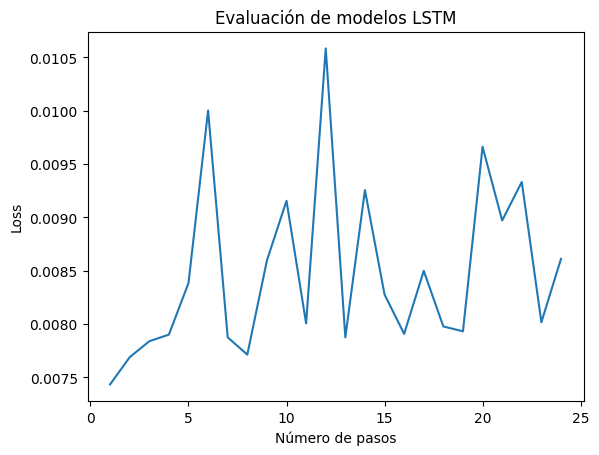

In [159]:
mejor_paso = evaluar_modelos_pasos(X, Y, nro_pasos= 25)

In [160]:
print('El mejor paso de tiempo es:', mejor_paso)

El mejor paso de tiempo es: 1


Vemos un mínimo en {{ mejor_paso }} pasos. Probemos ese modelo:

Model: "sequential_211"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_211 (LSTM)             (None, 50)                12800     
                                                                 
 dense_211 (Dense)           (None, 5)                 255       
                                                                 
Total params: 13055 (51.00 KB)
Trainable params: 13055 (51.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
37/37 [==============================] - 1s 7ms/step - loss: 0.0749 - val_loss: 0.0219
Epoch 2/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0261 - val_loss: 0.0321
Epoch 3/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0176 - val_loss: 0.0183
Epoch 4/50
37/37 [==============================] - 0s 2ms/step - loss: 0.0132 - val_loss: 0.0125
Epoch 5/50
37/37 [==

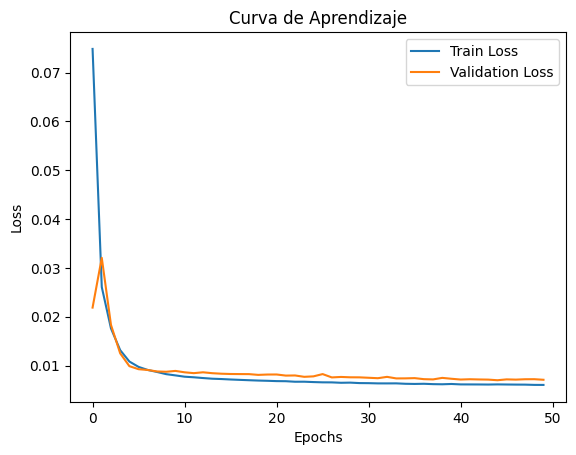

In [161]:
model, X_test_reshaped, Y_test_reshaped = construir_modelo(X, Y, nro_pasos=mejor_paso)

10/10 [==============================] - 0s 0s/step


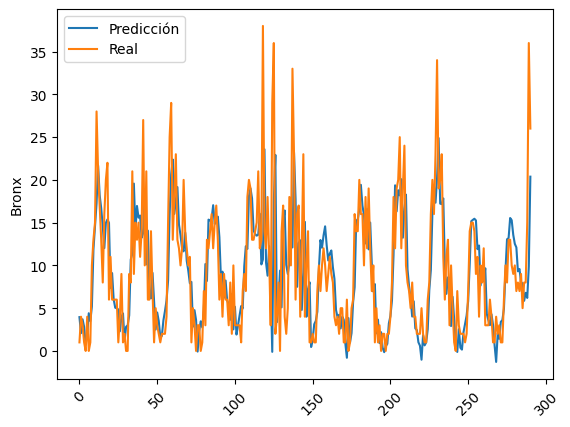

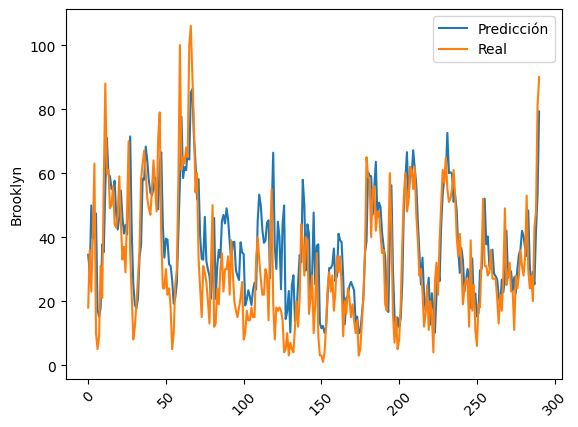

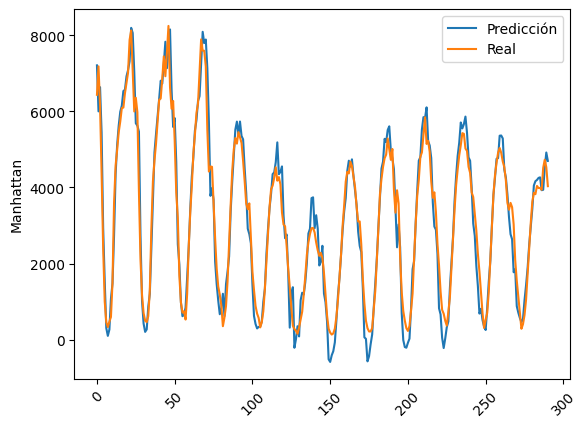

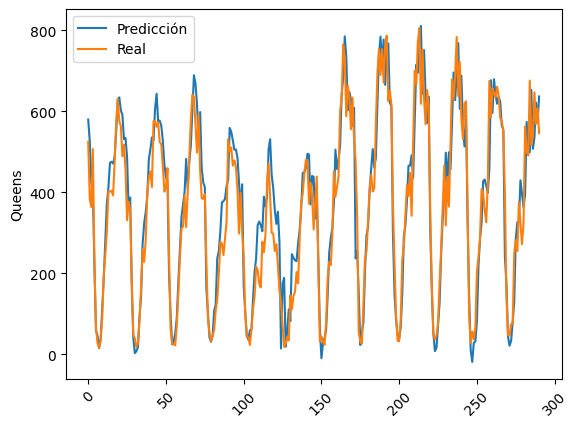

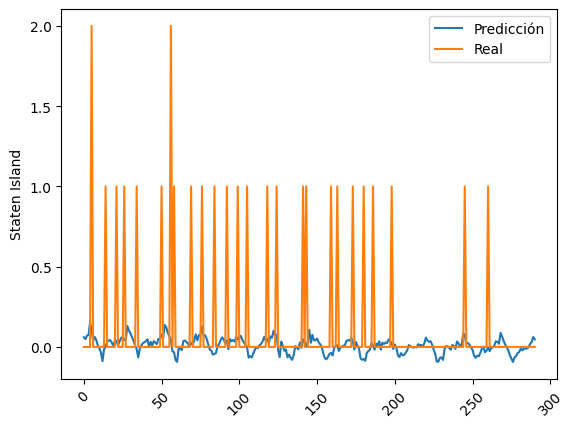

In [162]:
graficar_pred_test(X_test_reshaped, Y_test_reshaped)

Vemos que el modelo mejora mucho. Sin embargo, puede haber overfitting. Veamos si podemos mejorarlo añadiendo alguna variable. Por ejemplo, probemos agregar la variable 'número de día de la semana':

In [163]:
df.head()

,fecha,hora,temperature_2m,rain,relative_humidity_2m,snowfall,Bronx,Brooklyn,Manhattan,Queens,Staten Island,año,mes,dia
0,2023-11-01,0.0,8.6725,0.1,60.153034,0.0,3,12,2196,232,1,2023,11,1
1,2023-11-01,1.0,8.5725,0.0,60.344471,0.0,2,12,1521,55,0,2023,11,1
2,2023-11-01,2.0,8.3225,0.1,62.933163,0.0,3,8,1214,16,0,2023,11,1
3,2023-11-01,3.0,8.0725,0.0,66.100021,0.0,0,13,854,20,0,2023,11,1
4,2023-11-01,4.0,7.7725,0.0,72.938622,0.0,12,20,654,25,0,2023,11,1


In [7]:
df['nro_de_dia'] = df['fecha'].dt.weekday + 1
df.head()

,fecha,hora,temperature_2m,rain,relative_humidity_2m,snowfall,Bronx,Brooklyn,Manhattan,Queens,Staten Island,año,mes,dia,nro_de_dia
3,2023-11-01,0.0,8.6725,0.1,60.153034,0.0,3,12,2196,232,1,2023,11,1,3
4,2023-11-01,1.0,8.5725,0.0,60.344471,0.0,2,12,1521,55,0,2023,11,1,3
5,2023-11-01,2.0,8.3225,0.1,62.933163,0.0,3,8,1214,16,0,2023,11,1,3
6,2023-11-01,3.0,8.0725,0.0,66.100021,0.0,0,13,854,20,0,2023,11,1,3
7,2023-11-01,4.0,7.7725,0.0,72.938622,0.0,12,20,654,25,0,2023,11,1,3


In [8]:
columnas_X_nuevas = ['año', 'mes', 'dia', 'hora', 'nro_de_dia', 'temperature_2m', 'rain', 'relative_humidity_2m', 'snowfall']
X_nueva = df[columnas_X_nuevas]

columnas_Y= ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
Y_nueva = df[columnas_Y]

Probemos nuevamente la cantidad de pasos de tiempo adecuada

10/10 [==============================] - 0s 2ms/step - loss: 0.0075
Número de pasos 1 Loss (MSE): 0.007456895895302296
10/10 [==============================] - 0s 0s/step - loss: 0.0088
Número de pasos 2 Loss (MSE): 0.008767283521592617
9/9 [==============================] - 0s 753us/step - loss: 0.0087
Número de pasos 3 Loss (MSE): 0.008679872378706932
9/9 [==============================] - 0s 2ms/step - loss: 0.0095
Número de pasos 4 Loss (MSE): 0.009489447809755802
9/9 [==============================] - 0s 1ms/step - loss: 0.0100
Número de pasos 5 Loss (MSE): 0.010008654557168484
9/9 [==============================] - 0s 2ms/step - loss: 0.0102
Número de pasos 6 Loss (MSE): 0.010202274657785892
9/9 [==============================] - 0s 2ms/step - loss: 0.0104
Número de pasos 7 Loss (MSE): 0.010380249470472336
9/9 [==============================] - 0s 2ms/step - loss: 0.0109
Número de pasos 8 Loss (MSE): 0.01090906374156475
9/9 [==============================] - 0s 5ms/step - loss: 0

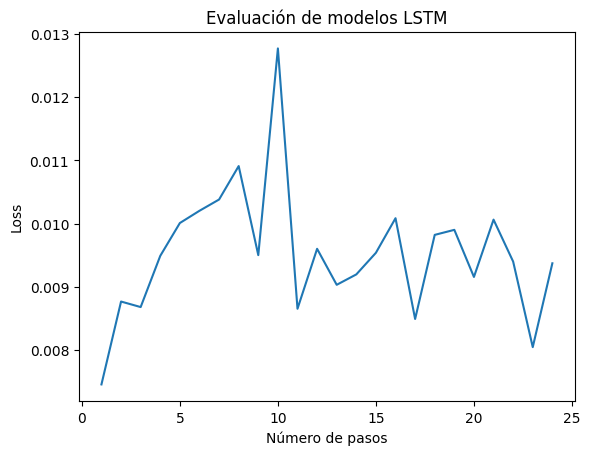

1

In [166]:
mejor_paso = evaluar_modelos_pasos(X_nueva, Y_nueva)

In [125]:
print('El mejor paso de tiempo es:', mejor_paso)

El mejor paso de tiempo es: 1


Model: "sequential_237"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_237 (LSTM)             (None, 50)                12800     
                                                                 
 dense_237 (Dense)           (None, 5)                 255       
                                                                 
Total params: 13055 (51.00 KB)
Trainable params: 13055 (51.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
37/37 [==============================] - 1s 7ms/step - loss: 0.0931 - val_loss: 0.0385
Epoch 2/50
37/37 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.0233
Epoch 3/50
37/37 [==============================] - 0s 2ms/step - loss: 0.0247 - val_loss: 0.0278
Epoch 4/50
37/37 [==============================] - 0s 2ms/step - loss: 0.0182 - val_loss: 0.0184
Epoch 5/50
37/37 [==

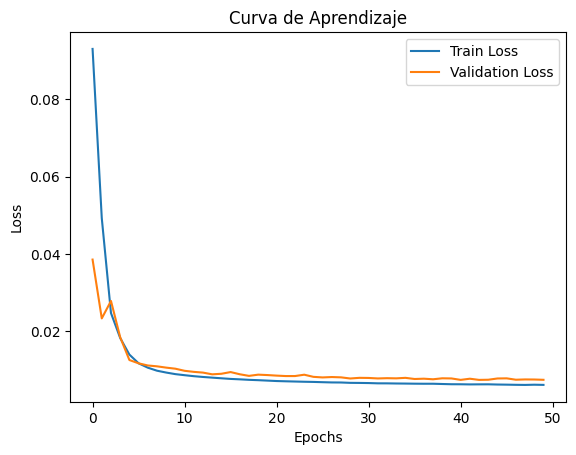

In [169]:
modelo, X_test_reshaped, Y_test_reshaped = construir_modelo(X, Y, nro_pasos=mejor_paso)

10/10 [==============================] - 0s 2ms/step


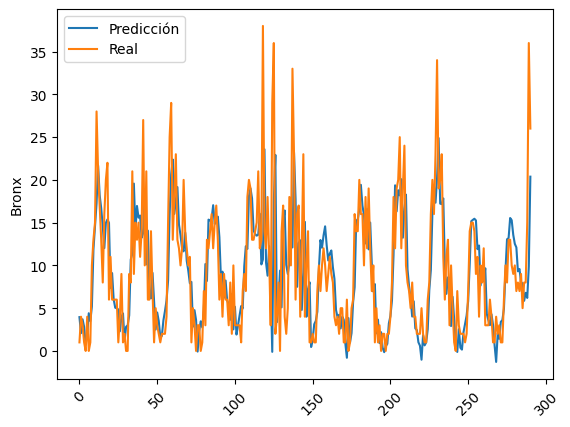

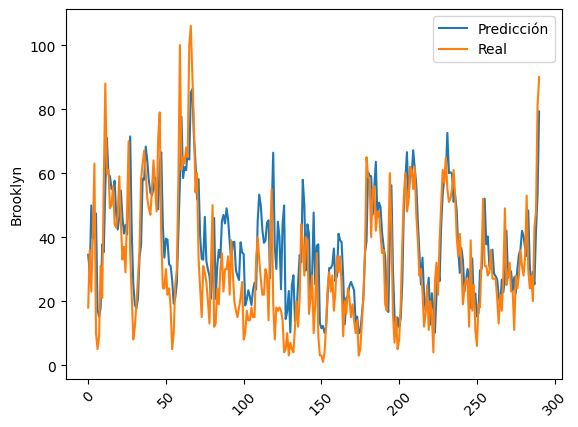

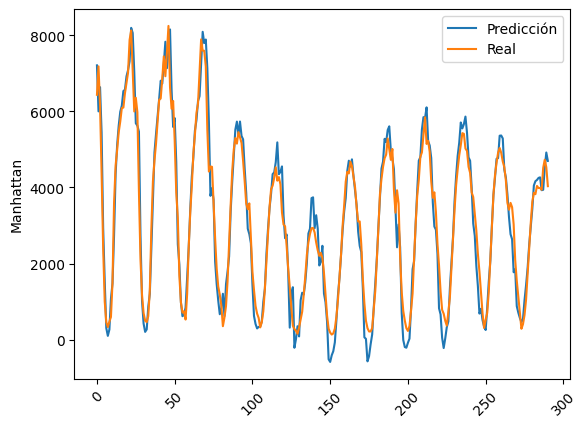

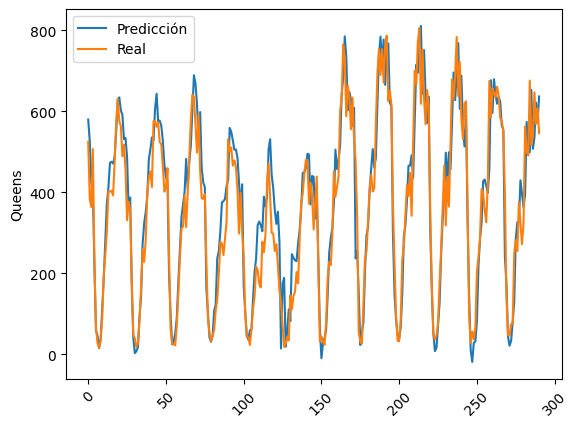

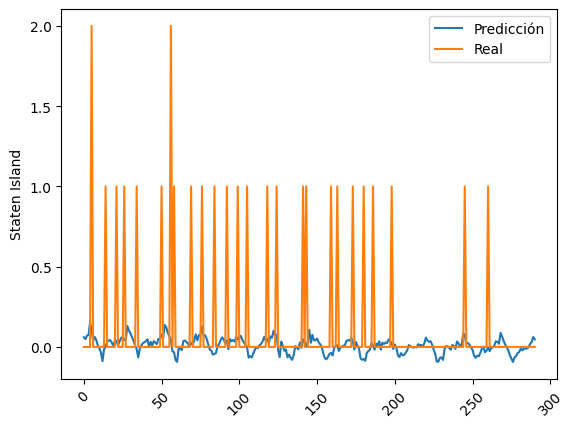

In [170]:
graficar_pred_test(X_test_reshaped, Y_test_reshaped)

Debido a que vemos que hay demandas negativas en la respuesta del modelo, vamos a evaluar utilizar la métrica MAE:

10/10 [==============================] - 0s 2ms/step - loss: 0.0554
Número de pasos 1 Loss (MSE): 0.05537039041519165
10/10 [==============================] - 0s 5ms/step - loss: 0.0544
Número de pasos 2 Loss (MSE): 0.05442085862159729
9/9 [==============================] - 0s 4ms/step - loss: 0.0535
Número de pasos 3 Loss (MSE): 0.05350629240274429
9/9 [==============================] - 0s 5ms/step - loss: 0.0613
Número de pasos 4 Loss (MSE): 0.06130744516849518
9/9 [==============================] - 0s 4ms/step - loss: 0.0586
Número de pasos 5 Loss (MSE): 0.058640286326408386
9/9 [==============================] - 0s 4ms/step - loss: 0.0534
Número de pasos 6 Loss (MSE): 0.05339591205120087
9/9 [==============================] - 0s 6ms/step - loss: 0.0568
Número de pasos 7 Loss (MSE): 0.05680006742477417
9/9 [==============================] - 0s 4ms/step - loss: 0.0595
Número de pasos 8 Loss (MSE): 0.0595465824007988
9/9 [==============================] - 0s 9ms/step - loss: 0.0572
Nú

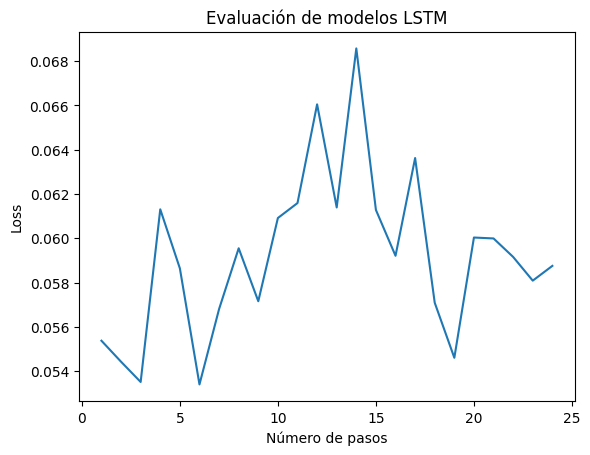

In [200]:
mejor_paso = evaluar_modelos_pasos(X_nueva, Y_nueva, loss_='mae')

In [201]:
print('El mejor paso de tiempo es:' , mejor_paso)

El mejor paso de tiempo es: 6


Model: "sequential_262"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_262 (LSTM)             (None, 50)                18000     
                                                                 
 dense_262 (Dense)           (None, 5)                 255       
                                                                 
Total params: 18255 (71.31 KB)
Trainable params: 18255 (71.31 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
37/37 [==============================] - 1s 8ms/step - loss: 0.1279 - val_loss: 0.0980
Epoch 2/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0815 - val_loss: 0.0995
Epoch 3/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0690 - val_loss: 0.0845
Epoch 4/50
37/37 [==============================] - 0s 4ms/step - loss: 0.0628 - val_loss: 0.0751
Epoch 5/50
37/37 [==

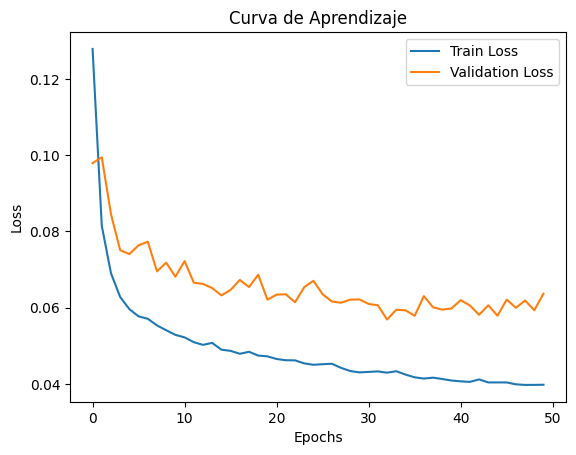

In [202]:
modelo, X_test_reshaped, Y_test_reshaped = construir_modelo(X_nueva, Y_nueva, nro_pasos=mejor_paso, loss_= 'mae')

In [204]:
X_test_reshaped.shape

(281, 6, 39)

In [205]:
Y_test_reshaped.shape

(281, 5)

9/9 [==============================] - 0s 2ms/step


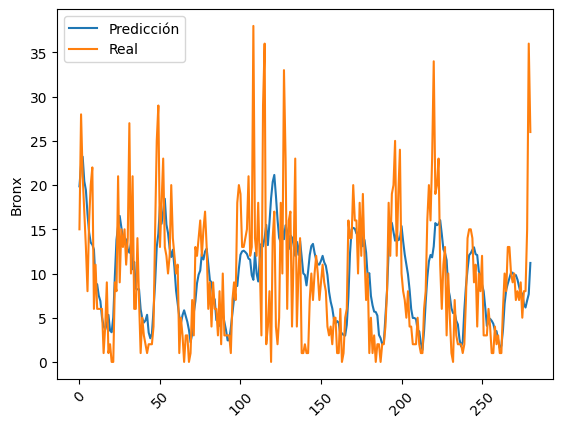

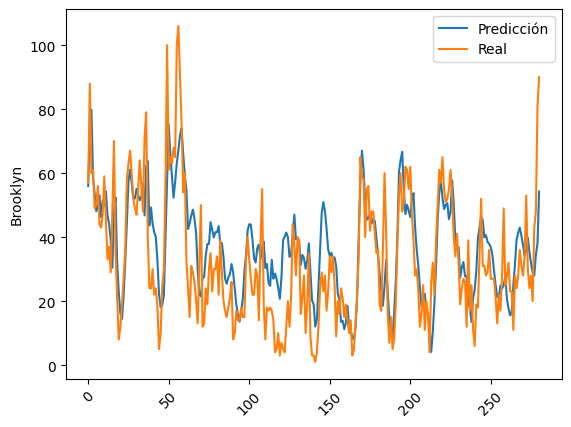

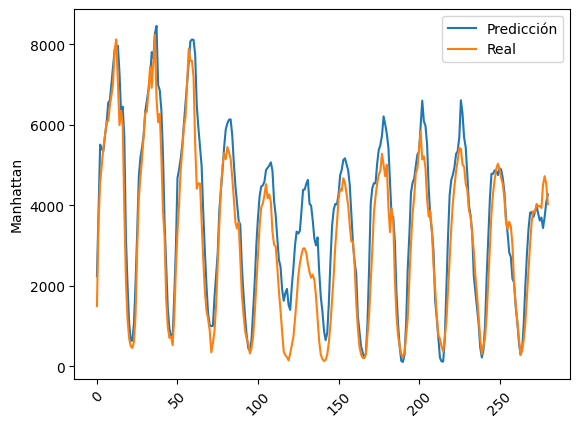

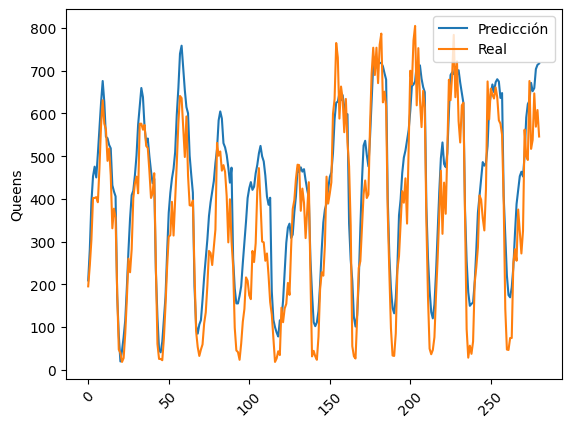

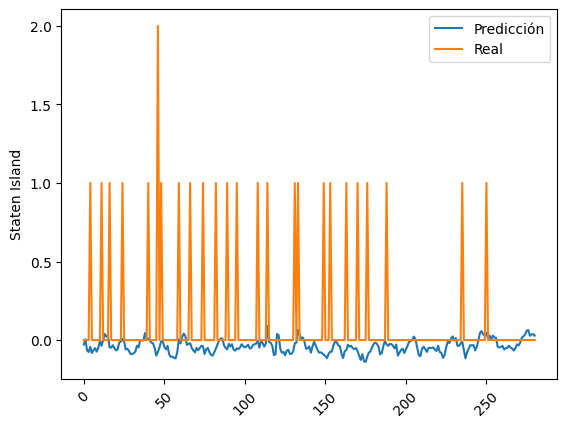

In [207]:
graficar_pred_test(X_test_reshaped, Y_test_reshaped, modelo)

Seguimos viendo que, a valores bajos o cero de demanda, el modelo predice demanda negativa. Probemos con activación 'Relu' en la capa de salida:

10/10 [==============================] - 0s 1ms/step - loss: 0.0336
Número de pasos 1 Loss (MSE): 0.033614810556173325
10/10 [==============================] - 0s 2ms/step - loss: 0.0082
Número de pasos 2 Loss (MSE): 0.008220975287258625
9/9 [==============================] - 0s 2ms/step - loss: 0.0084
Número de pasos 3 Loss (MSE): 0.00836149975657463
9/9 [==============================] - 0s 2ms/step - loss: 0.0101
Número de pasos 4 Loss (MSE): 0.010126105509698391
9/9 [==============================] - 0s 2ms/step - loss: 0.0097
Número de pasos 5 Loss (MSE): 0.009711046703159809
9/9 [==============================] - 0s 2ms/step - loss: 0.0086
Número de pasos 6 Loss (MSE): 0.008608565665781498
9/9 [==============================] - 0s 2ms/step - loss: 0.0099
Número de pasos 7 Loss (MSE): 0.009911715053021908
9/9 [==============================] - 0s 2ms/step - loss: 0.0106
Número de pasos 8 Loss (MSE): 0.010586421005427837
9/9 [==============================] - 0s 2ms/step - loss: 0.

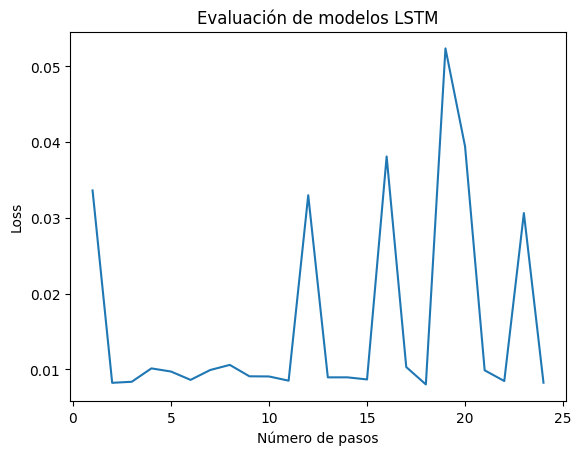

In [212]:
mejor_paso = evaluar_modelos_pasos(X_nueva, Y_nueva, act_salida= 'relu')

In [213]:
print('Mejor paso de tiempo:', mejor_paso)

Mejor paso de tiempo: 18


Model: "sequential_287"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_287 (LSTM)             (None, 50)                30000     
                                                                 
 dense_287 (Dense)           (None, 5)                 255       
                                                                 
Total params: 30255 (118.18 KB)
Trainable params: 30255 (118.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
36/36 [==============================] - 1s 13ms/step - loss: 0.0410 - val_loss: 0.0348
Epoch 2/50
36/36 [==============================] - 0s 6ms/step - loss: 0.0252 - val_loss: 0.0314
Epoch 3/50
36/36 [==============================] - 0s 5ms/step - loss: 0.0230 - val_loss: 0.0294
Epoch 4/50
36/36 [==============================] - 0s 6ms/step - loss: 0.0219 - val_loss: 0.0280
Epoch 5/50
36/36 

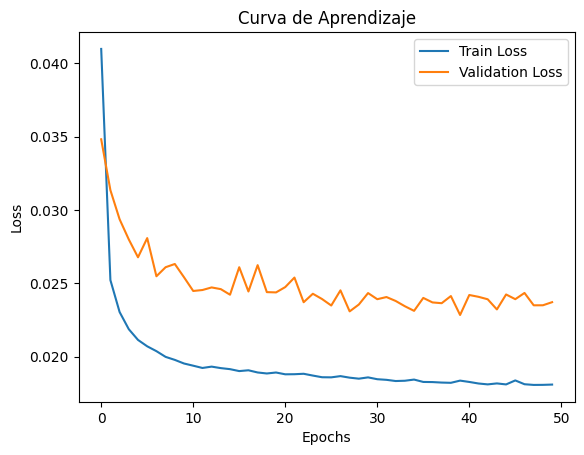

In [214]:
modelo, X_test_reshaped, Y_test_reshaped = construir_modelo(X_nueva, Y_nueva, act_salida= 'relu', nro_pasos=mejor_paso)

9/9 [==============================] - 0s 3ms/step


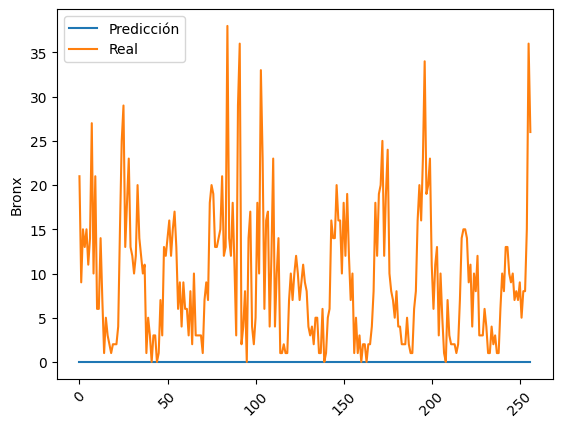

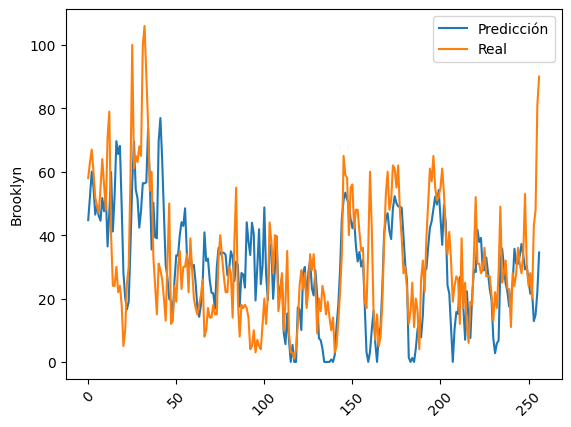

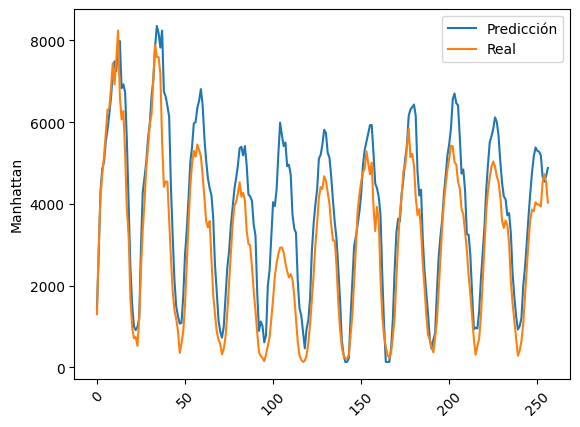

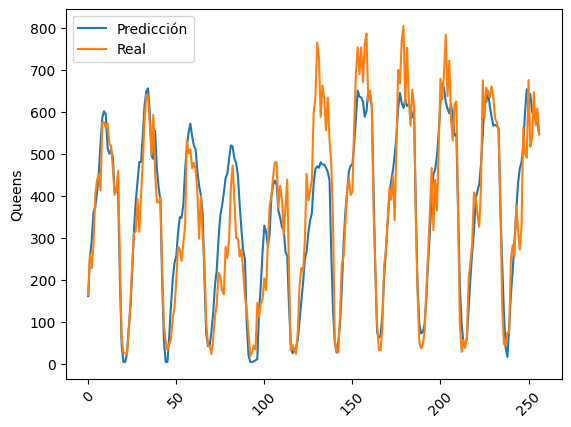

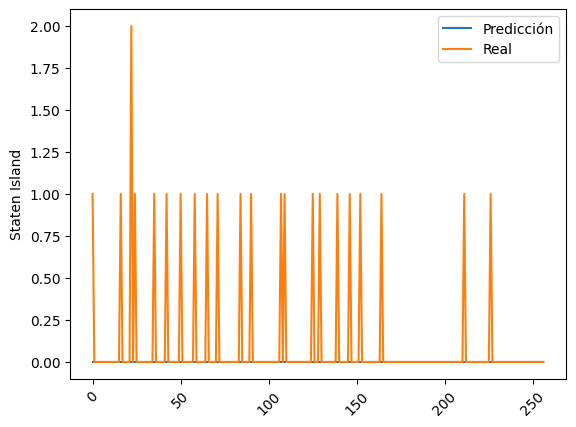

In [215]:
graficar_pred_test(X_test_reshaped, Y_test_reshaped, modelo)

La activación Relu en la capa de salida, elimina los negativos pero los deja en cero. Probemos con la activación sigmoide:

10/10 [==============================] - 0s 2ms/step - loss: 0.0080
Número de pasos 1 Loss (MSE): 0.00801320094615221
10/10 [==============================] - 0s 2ms/step - loss: 0.0076
Número de pasos 2 Loss (MSE): 0.007579926401376724
9/9 [==============================] - 0s 457us/step - loss: 0.0093
Número de pasos 3 Loss (MSE): 0.00930507481098175
9/9 [==============================] - 0s 2ms/step - loss: 0.0093
Número de pasos 4 Loss (MSE): 0.009334013797342777
9/9 [==============================] - 0s 2ms/step - loss: 0.0090
Número de pasos 5 Loss (MSE): 0.009022149257361889
9/9 [==============================] - 0s 2ms/step - loss: 0.0099
Número de pasos 6 Loss (MSE): 0.009860148653388023
9/9 [==============================] - 0s 2ms/step - loss: 0.0098
Número de pasos 7 Loss (MSE): 0.009770149365067482
9/9 [==============================] - 0s 2ms/step - loss: 0.0080
Número de pasos 8 Loss (MSE): 0.008044077083468437
9/9 [==============================] - 0s 2ms/step - loss: 0

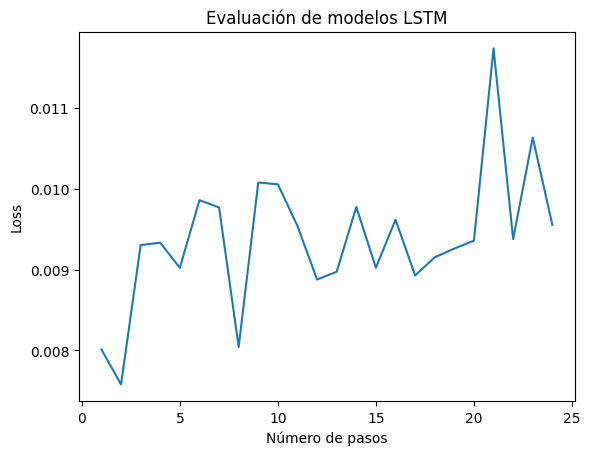

In [217]:
mejor_paso = evaluar_modelos_pasos(X_nueva, Y_nueva, act_salida= 'sigmoid')

In [218]:
print('El mejor paso de tiempo es:', mejor_paso)

El mejor paso de tiempo es: 2


Model: "sequential_314"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_314 (LSTM)             (None, 50)                14000     
                                                                 
 dense_314 (Dense)           (None, 5)                 255       
                                                                 
Total params: 14255 (55.68 KB)
Trainable params: 14255 (55.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
37/37 [==============================] - 1s 7ms/step - loss: 0.1075 - val_loss: 0.0707
Epoch 2/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0535 - val_loss: 0.0336
Epoch 3/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0335 - val_loss: 0.0232
Epoch 4/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0248 - val_loss: 0.0176
Epoch 5/50
37/37 [==

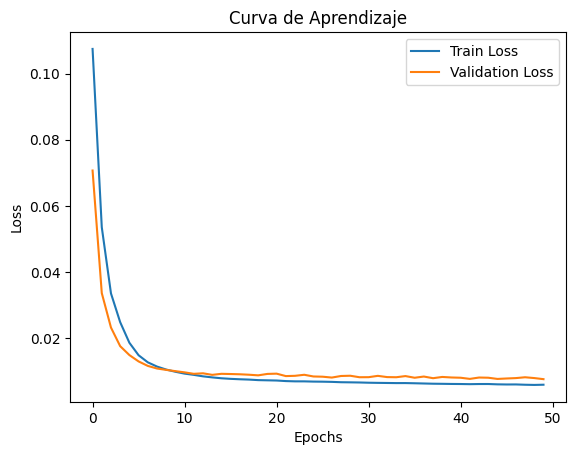

In [219]:
modelo, X_test_reshaped, Y_test_reshaped = construir_modelo(X_nueva, Y_nueva, act_salida='sigmoid', nro_pasos=mejor_paso)

10/10 [==============================] - 0s 2ms/step


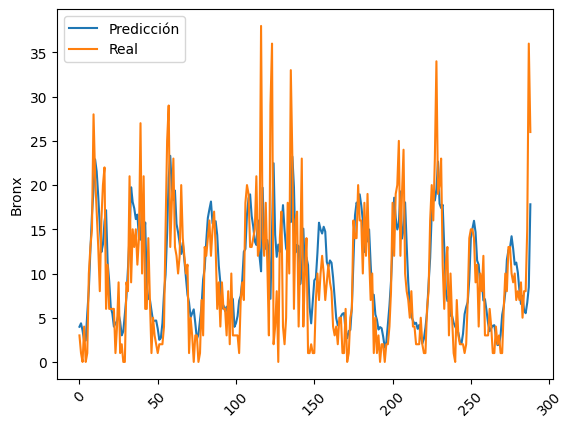

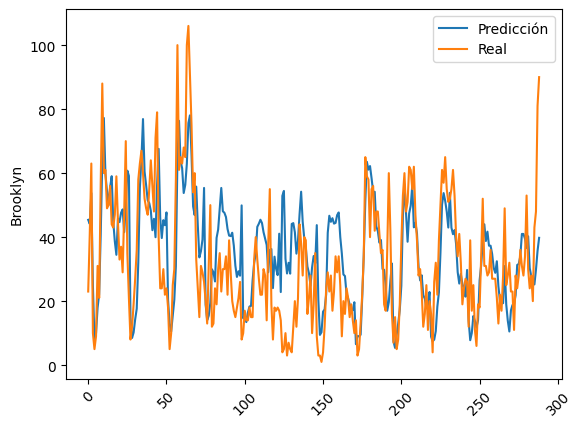

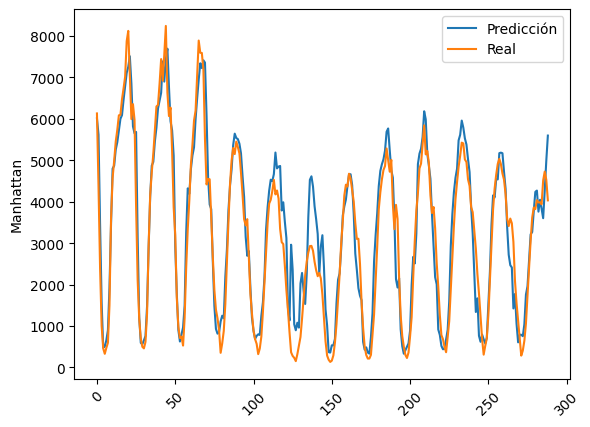

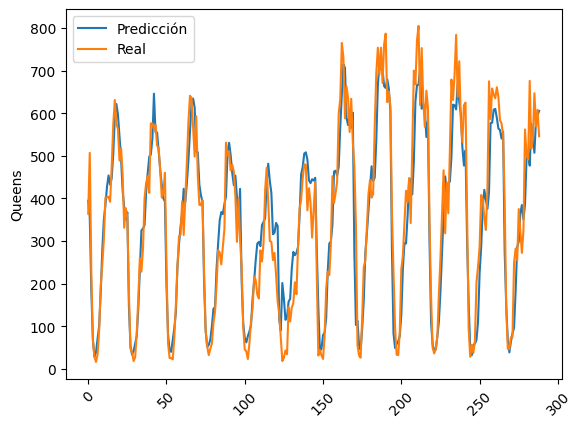

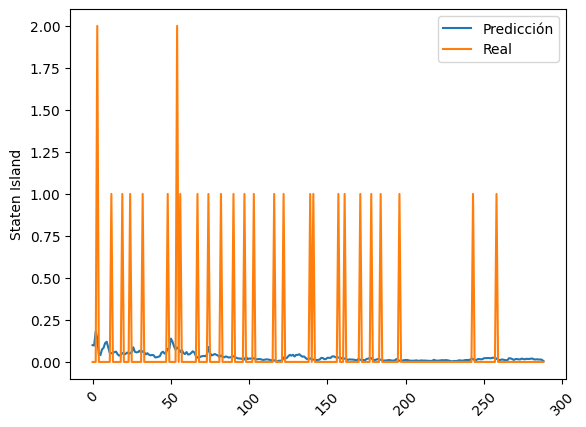

In [220]:
graficar_pred_test(X_test_reshaped, Y_test_reshaped, modelo)

Evaluemos ahora la cantidad de capas LSTM y de unidades en cada capa:

Número de capas LSTM=  1
Model: "sequential_336"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_352 (LSTM)             (None, 50)                14000     
                                                                 
 dense_333 (Dense)           (None, 5)                 255       
                                                                 
Total params: 14255 (55.68 KB)
Trainable params: 14255 (55.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Valor final de Loss: 0.007683870382606983


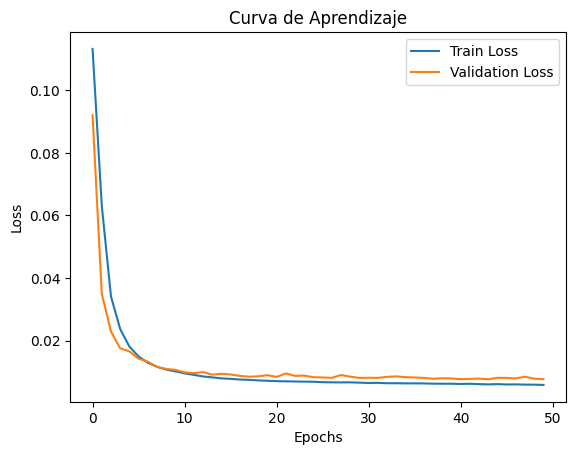

Número de capas LSTM=  2
Model: "sequential_337"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_353 (LSTM)             (None, 2, 50)             14000     
                                                                 
 lstm_354 (LSTM)             (None, 10)                2440      
                                                                 
 dense_334 (Dense)           (None, 5)                 55        
                                                                 
Total params: 16495 (64.43 KB)
Trainable params: 16495 (64.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Valor final de Loss: 0.010048785246908665


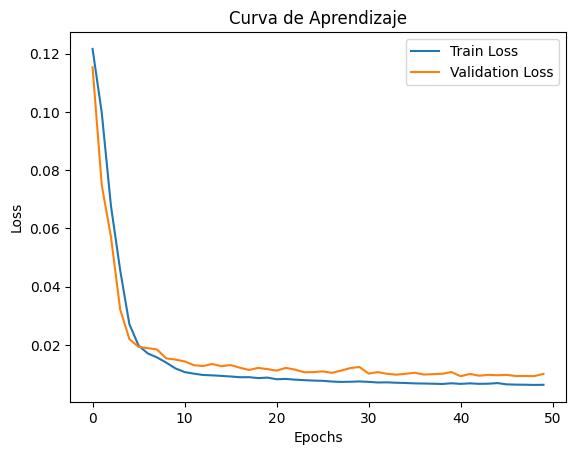

Número de capas LSTM=  3
Model: "sequential_338"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_355 (LSTM)             (None, 2, 50)             14000     
                                                                 
 lstm_356 (LSTM)             (None, 2, 40)             14560     
                                                                 
 lstm_357 (LSTM)             (None, 10)                2040      
                                                                 
 dense_335 (Dense)           (None, 5)                 55        
                                                                 
Total params: 30655 (119.75 KB)
Trainable params: 30655 (119.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Valor final de Loss: 0.00839811097830534


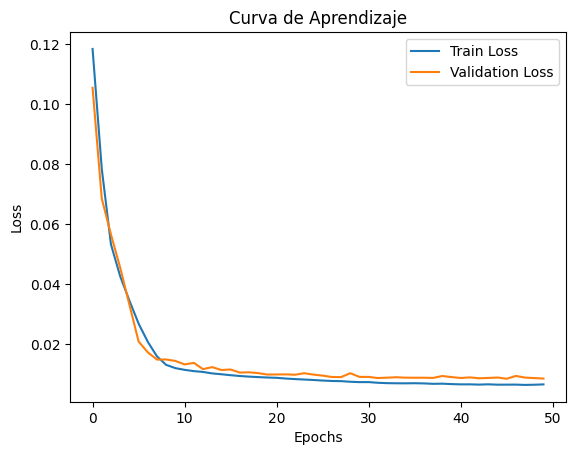

Número de capas LSTM=  4
Model: "sequential_339"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_358 (LSTM)             (None, 2, 50)             14000     
                                                                 
 lstm_359 (LSTM)             (None, 2, 40)             14560     
                                                                 
 lstm_360 (LSTM)             (None, 2, 30)             8520      
                                                                 
 lstm_361 (LSTM)             (None, 10)                1640      
                                                                 
 dense_336 (Dense)           (None, 5)                 55        
                                                                 
Total params: 38775 (151.46 KB)
Trainable params: 38775 (151.46 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________________________________________

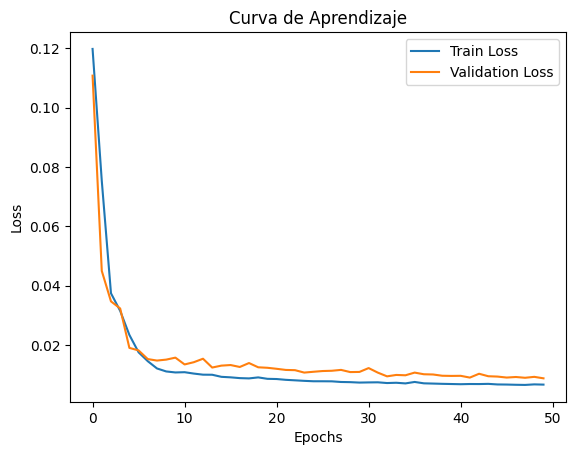

Número de capas LSTM=  5
Model: "sequential_340"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_362 (LSTM)             (None, 2, 50)             14000     
                                                                 
 lstm_363 (LSTM)             (None, 2, 40)             14560     
                                                                 
 lstm_364 (LSTM)             (None, 2, 30)             8520      
                                                                 
 lstm_365 (LSTM)             (None, 2, 20)             4080      
                                                                 
 lstm_366 (LSTM)             (None, 10)                1240      
                                                                 
 dense_337 (Dense)           (None, 5)                 55        
                                                                 
Total params: 42455 (165.84

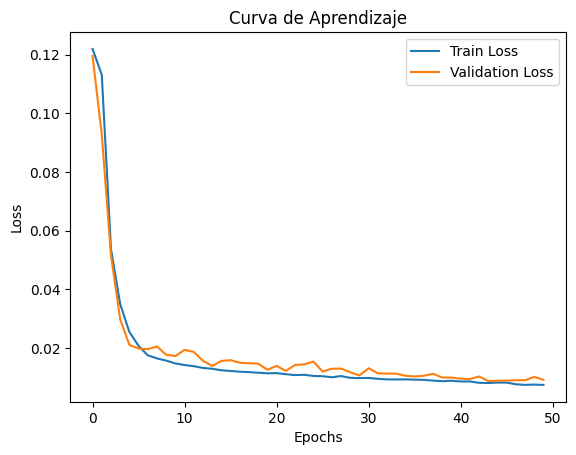

In [259]:
for i in range(1,6):
    print('Número de capas LSTM= ', i)
    modelo, X_test_reshaped, Y_test_reshaped = construir_modelo(X_nueva, Y_nueva, nro_pasos=2, 
                                                                      nro_capas_lstm=i, unidades_capa=[50, 40, 30, 20, 10], act_salida='sigmoid')

Vemos que la menor pérdida la tenemos con una sola capa LSTM

Ahora probemos cambiando la función de activación de las capas LSTM a 'sigmoid':

10/10 [==============================] - 0s 1ms/step - loss: 0.0097
Número de pasos 1 Loss (MSE): 0.009654797613620758
10/10 [==============================] - 0s 519us/step - loss: 0.0098
Número de pasos 2 Loss (MSE): 0.009823975153267384
9/9 [==============================] - 0s 852us/step - loss: 0.0098
Número de pasos 3 Loss (MSE): 0.009818727150559425
9/9 [==============================] - 0s 2ms/step - loss: 0.0093
Número de pasos 4 Loss (MSE): 0.009301606565713882
9/9 [==============================] - 0s 2ms/step - loss: 0.0094
Número de pasos 5 Loss (MSE): 0.009401513263583183
9/9 [==============================] - 0s 507us/step - loss: 0.0089
Número de pasos 6 Loss (MSE): 0.00889867078512907
9/9 [==============================] - 0s 2ms/step - loss: 0.0090
Número de pasos 7 Loss (MSE): 0.00897534191608429
9/9 [==============================] - 0s 4ms/step - loss: 0.0097
Número de pasos 8 Loss (MSE): 0.009701530449092388
9/9 [==============================] - 0s 3ms/step - los

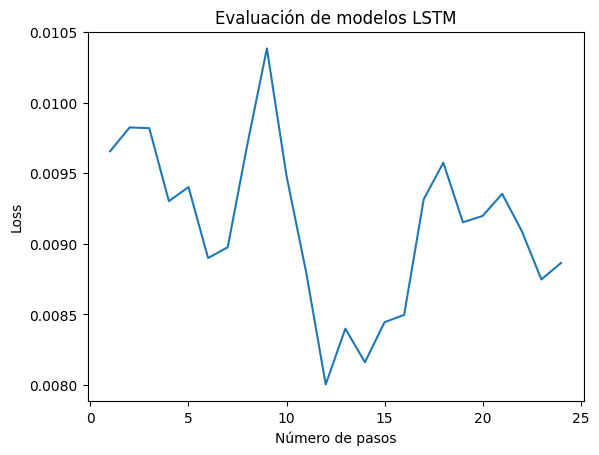

In [263]:
mejor_paso = evaluar_modelos_pasos(X_nueva, Y_nueva, act_salida='sigmoid', act_lstm='sigmoid')

In [264]:
print('El mejor paso de tiempo es:', mejor_paso)

El mejor paso de tiempo es: 12




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                24000     
                                                                 
 dense (Dense)               (None, 5)                 255       
                                                                 
Total params: 24255 (94.75 KB)
Trainable params: 24255 (94.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Valor final de Loss: 0.008368967100977898


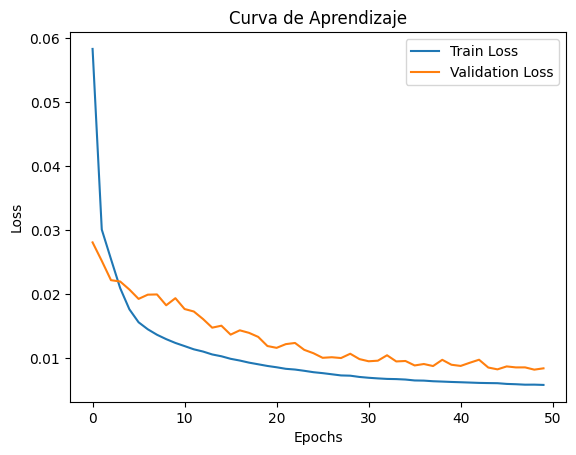

In [9]:
modelo, X_test_reshaped, Y_test_reshaped, scaler_Y = construir_modelo(X_nueva, Y_nueva, act_lstm='sigmoid', act_salida='sigmoid', nro_pasos=12)

9/9 [==============================] - 0s 2ms/step


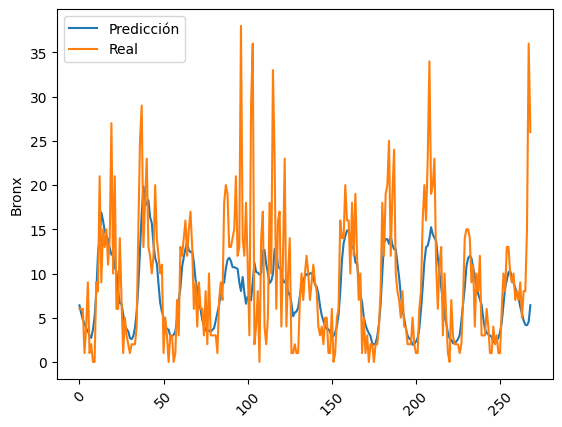

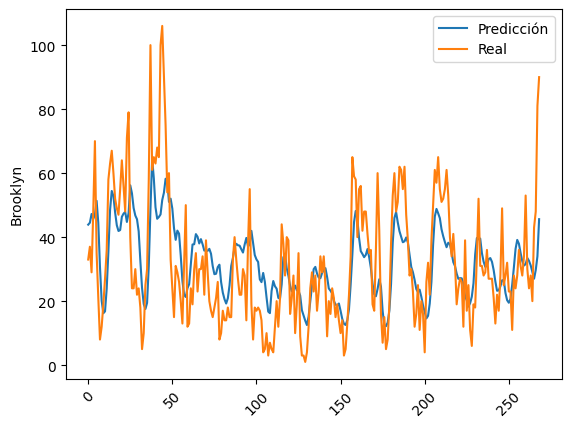

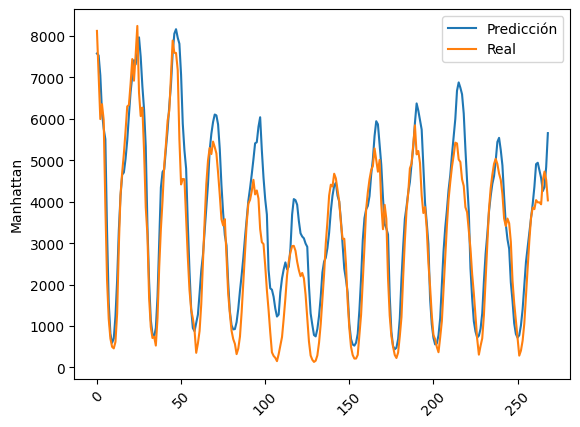

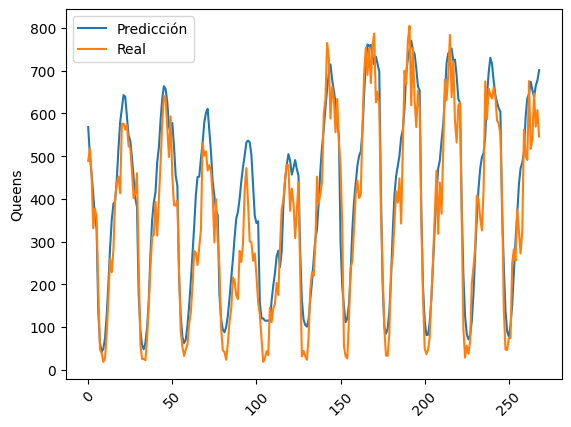

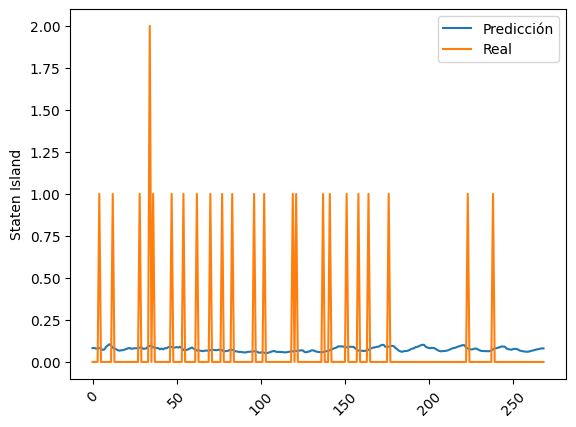

In [10]:
graficar_pred_test(X_test_reshaped, Y_test_reshaped, modelo, scaler_Y)

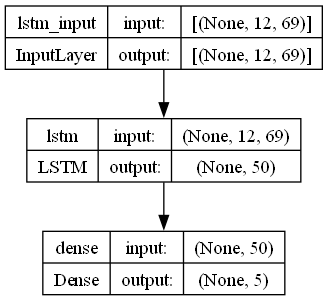

In [24]:
plot_model(modelo, to_file='model_plot.png', show_shapes=True, show_layer_names=True, rankdir='TB')